In [17]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Transition table

In [18]:
from collections import defaultdict
import nltk

def count_transitions(tokens):
    transition_counts = defaultdict(lambda: defaultdict(int))
    for i in range(len(tokens)-1):
        curent, next_ = tokens[i], tokens[i + 1]
        transition_counts[next_][curent] += 1
    return transition_counts

text = """Lata osa koło nosa
Lata mucha koło ucha
Lata bąk koło rąk"""

tokens = nltk.word_tokenize(text)
tokens = [token.lower() for token in tokens if token.isalpha()]
transitions = count_transitions(tokens)

print("Transition counts:")
df = pd.DataFrame(data=transitions)
df.fillna(value=0, inplace=True)
print(df)

print("\nTransition probabilities:")
df = df.div(df.sum(axis=1), axis=0)
df.fillna(value=0, inplace=True)
print(df)

Transition counts:
       osa  koło  nosa  lata  mucha  ucha  bąk  rąk
bąk    0.0   1.0   0.0   0.0    0.0   0.0  0.0  0.0
koło   0.0   0.0   1.0   0.0    0.0   1.0  0.0  1.0
lata   1.0   0.0   0.0   0.0    1.0   0.0  1.0  0.0
mucha  0.0   1.0   0.0   0.0    0.0   0.0  0.0  0.0
nosa   0.0   0.0   0.0   1.0    0.0   0.0  0.0  0.0
osa    0.0   1.0   0.0   0.0    0.0   0.0  0.0  0.0
ucha   0.0   0.0   0.0   1.0    0.0   0.0  0.0  0.0

Transition probabilities:
        osa  koło  nosa  lata  mucha  ucha   bąk   rąk
bąk    0.00   1.0  0.00   0.0   0.00  0.00  0.00  0.00
koło   0.00   0.0  0.33   0.0   0.00  0.33  0.00  0.33
lata   0.33   0.0  0.00   0.0   0.33  0.00  0.33  0.00
mucha  0.00   1.0  0.00   0.0   0.00  0.00  0.00  0.00
nosa   0.00   0.0  0.00   1.0   0.00  0.00  0.00  0.00
osa    0.00   1.0  0.00   0.0   0.00  0.00  0.00  0.00
ucha   0.00   0.0  0.00   1.0   0.00  0.00  0.00  0.00


In [19]:
from collections import defaultdict
import nltk

def count_transitions(tokens, n):
    transition_counts = defaultdict(lambda: defaultdict(int))
    for i in range(len(tokens)-n):
        curent, next_ = " ".join(tokens[i:i+n]), tokens[i + n]
        transition_counts[next_][curent] += 1
    return transition_counts

text = """Lata osa koło nosa
Lata mucha koło ucha
Lata bąk koło rąk"""

tokens = nltk.word_tokenize(text)
tokens = [token.lower() for token in tokens if token.isalpha()]
transitions = count_transitions(tokens, n=2)

print("Transition counts:")
df = pd.DataFrame(data=transitions)
df.fillna(value=0, inplace=True)
print(df)

print("\nTransition probabilities:")
df = df.div(df.sum(axis=1), axis=0)
df.fillna(value=0, inplace=True)
print(df)

Transition counts:
            koło  nosa  lata  mucha  ucha  bąk  rąk
bąk koło     0.0   0.0   0.0    0.0   0.0  0.0  1.0
koło nosa    0.0   0.0   1.0    0.0   0.0  0.0  0.0
koło ucha    0.0   0.0   1.0    0.0   0.0  0.0  0.0
lata bąk     1.0   0.0   0.0    0.0   0.0  0.0  0.0
lata mucha   1.0   0.0   0.0    0.0   0.0  0.0  0.0
lata osa     1.0   0.0   0.0    0.0   0.0  0.0  0.0
mucha koło   0.0   0.0   0.0    0.0   1.0  0.0  0.0
nosa lata    0.0   0.0   0.0    1.0   0.0  0.0  0.0
osa koło     0.0   1.0   0.0    0.0   0.0  0.0  0.0
ucha lata    0.0   0.0   0.0    0.0   0.0  1.0  0.0

Transition probabilities:
            koło  nosa  lata  mucha  ucha  bąk  rąk
bąk koło     0.0   0.0   0.0    0.0   0.0  0.0  1.0
koło nosa    0.0   0.0   1.0    0.0   0.0  0.0  0.0
koło ucha    0.0   0.0   1.0    0.0   0.0  0.0  0.0
lata bąk     1.0   0.0   0.0    0.0   0.0  0.0  0.0
lata mucha   1.0   0.0   0.0    0.0   0.0  0.0  0.0
lata osa     1.0   0.0   0.0    0.0   0.0  0.0  0.0
mucha koło   0.0  

# Text generation

In [20]:
from collections import defaultdict, Counter
import random

class NGramCharModel:

    def __init__(self, file_path, n):
        """
        Parameters
        ----------
        file_path : str
            Path to file which will be used to create language model.
        n : int
            Length of characters n-gram.
        """
        self.file_path = file_path
        self.n = n
        self.model = None

    def normalize(self, counter):
        """
        Normalize counts of characters following a n-gram of characters.
        Counts are divided by total number of characters that followed
        the n-gram resulting in probabilities of characters occurrecnces.

        Parameters
        ----------
        counter : mapping {str: {char: int, ...}}
            Character n-grams to occurrences of characters.

        Returns
        -------
        mapping {str: {char: float, ...}}
           Character n-grams to probabilities of character occurrences.
        """
        s = float(sum(counter.values()))
        return [(c, cnt / s) for c, cnt in counter.items()]

    def train(self):
        """ Trains a language model. """
        data = open(self.file_path).read()
        model = defaultdict(Counter)
        for i in range(len(data)-self.n):
            n_gram, c = data[i:i+self.n], data[i+self.n]
            model[n_gram][c] += 1
        self.model = {n_gram: self.normalize(c) for n_gram, c in model.items()}

    def generate_letter(self, history):
        """
        Parameters
        ----------
        history : str
            Text generated so far.

        Returns
        -------
        str
            A character.
        """
        n_gram = history[-self.n:]
        distribution = self.model[n_gram]
        characters, weights = zip(*distribution)
        choice = random.choices(population=characters, weights=weights, k=1)[0]
        return choice

    def generate_text(self, n_letters=500):
        """
        Generate specified number of charactes basing on last charcters n-gram 
        and probabilities of charcters that can follow it.

        Parameters
        ----------
        n_letters : int
            Length of a text to generate.

        Returns
        -------
        str
            Generated text.
        """
        history = random.choice(list(self.model))
        for _ in range(n_letters):
            c = self.generate_letter(history)
            history += c
        return history


if __name__ == "__main__":
    model = NGramCharModel(file_path="pan_tadeusz.txt", n=7)
    model.train()
    print(model.generate_text())

esarzu! Litwa ochotnika;
Kto wie, co się dziecię krzykliwe złożone wszyscy, kiedy resztę ułożym.

    Zosia mówił — księże bernardyn wzruszenie przeczył i z powieści, pytań,
Wykrzykniono znowu. Tryumf był niezmiennym,
Z oczyma wzniesionymi w niewoli, okuty w powiciu,
Ja tylko zgadywano, że pan grosza brak w Księstwa uciekają strwożył.
Aż gdy na rozbój zanosi.
Jęknęli wszystkie razem dzięcielina pała,
A znów trzymając każdy znawca ten rzęd chwalił,
Tyle scen dramatycznych wrzask i gęsto gniazdem są owad


# Visualization

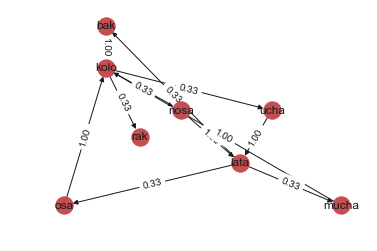

In [21]:
import networkx as nx

def utf2ascii(s):
    for a, b in zip("łą", "la"):
        s = s.replace(a, b)
    return s

def count_transitions(tokens, n):
    transition_counts = defaultdict(lambda: defaultdict(int))
    for i in range(len(tokens)-n):
        curent, next_ = " ".join(tokens[i:i+n]), tokens[i + n]
        transition_counts[next_][curent] += 1
    return transition_counts

text = """Lata osa koło nosa
Lata mucha koło ucha
Lata bąk koło rąk"""

text = utf2ascii(text)  # networkx package doesn't handle UTF characters so they have to be removed.
tokens = nltk.word_tokenize(text)
tokens = [token.lower() for token in tokens if token.isalpha()]
transitions = count_transitions(tokens, n=1)
df = pd.DataFrame(data=transitions)
df.fillna(value=0, inplace=True)
df = df.div(df.sum(axis=1), axis=0)
df.fillna(value=0, inplace=True)

graph = nx.MultiDiGraph()
for row_index in df.index:
    for column_header in df.columns:
        weight = df.loc[row_index, column_header]
        if weight > 0:
            weight = "{:.2f}".format(weight)
            u = row_index
            v = column_header
            graph.add_edge(u, v, weight=weight, label=weight)

pos = nx.drawing.nx_pydot.graphviz_layout(graph, prog='dot')
edge_labels = {(u, v): d['label'] for u, v, d in graph.edges(data=True)}
nx.draw_networkx(graph, pos)
nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels)
plt.axis('off')
plt.show()